# Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from IPython.core.display_functions import display
from PIL import Image, ImageOps
from torchvision.transforms import Compose, Resize, ToTensor
# import cv2 as cv
from collections import deque

import torch.optim as optim
import torch
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
import os
# from einops import rearrange, reduce, repeat
# from einops.layers.torch import Rearrange, Reduce
# from torchsummary import summary
# from torch.distributions import Categorical

In [2]:
def generate_cropped_im(im, cropped_dims):
    h_shift = 10
    s_shift = 10
    v_shift = 50
    # generate random crop shifts
    crop_attributes = {}
    cropped_shift = [np.random.randint(0,im.size[0]-cropped_dims[0]),np.random.randint(0,im.size[1]-cropped_dims[1])]
    # cropped_shift = [37,37]
    crop_coords = (cropped_shift[0], cropped_shift[1], cropped_shift[0]+cropped_dims[0], cropped_shift[1]+cropped_dims[1])
    cropped_im = im.crop(crop_coords)
    cropped_im = cropped_im.convert('HSV')
    h, s, v = cropped_im.split()
    h = h.point(lambda p: p + h_shift)
    s = s.point(lambda p: p + s_shift)
    v = v.point(lambda p: p + v_shift)
    cropped_im = Image.merge('HSV', (h, s, v))
    cropped_im = cropped_im.convert('RGB')
    cropped_im_shape = cropped_im.size
    crop_attributes['crop_coords'] = crop_coords
    crop_attributes['cropped_shift'] = cropped_shift
    crop_attributes['cropped_im'] = cropped_im
    crop_attributes['cropped_im_shape'] = cropped_im_shape
    
    return crop_attributes

In [84]:
class Env:
    def __init__(self, fixed_image, moving_image, crop_coords=(37, 37, 74, 74)):
        self.crop_coords = crop_coords
        self.fixed_image = fixed_image
        self.moving_image = moving_image
        self.fixed_x = fixed_image.size[0]
        self.fixed_y = fixed_image.size[1]
        self.crop_x = crop_coords[0]
        self.crop_y = crop_coords[1]
        self.shift_x = 0
        self.shift_y = 0
        self.x_limit = fixed_image.size[0] - moving_image.size[0]
        self.y_limit = fixed_image.size[1] - moving_image.size[1]
        self.env_image = fixed_image.copy()
        self.env_image.paste(moving_image, (0,0))
        self.action_space = 4

#     def reset(self):
#         # move image to a random position
#         print(self.x_limit)
#         self.shift_x = np.random.randint(0, self.x_limit)
#         self.shift_y = np.random.randint(0, self.y_limit)
#         self.env_image = self.fixed_image.copy()
#         self.env_image.paste(self.moving_image, (self.shift_x, self.shift_y))
#         return self.env_image
    
    def reset(self):
        crop_attr = generate_cropped_im(self.fixed_image, [37,37])
        self.crop_coords = crop_attr['crop_coords']
        print(f"Crop coords: {self.crop_coords}")
        self.moving_image = crop_attr['cropped_im']
        self.crop_x = self.crop_coords[0]
        self.crop_y = self.crop_coords[1]
        self.x_limit = self.fixed_image.size[0] - self.moving_image.size[0]
        self.y_limit = self.fixed_image.size[1] - self.moving_image.size[1]
        # move image to a random position
        print(self.x_limit)
        self.shift_x = np.random.randint(0, self.x_limit)
        self.shift_y = np.random.randint(0, self.y_limit)
        self.env_image = self.fixed_image.copy()
        self.env_image.paste(self.moving_image, (self.shift_x, self.shift_y))
        
        return self.env_image

    def check_frame(self, _im):
        _im_shape = _im.size
        _im_shape = [_im_shape[0] - 1, _im_shape[1] - 1]
        # check bottom border
        for i in range(_im_shape[0]):
            px = _im.getpixel((i, 0))
            if not (px[0] == 0 and px[1] == 0 and px[2] == 0):
                return False
        # check top border
        for i in range(_im_shape[0]):
            px = _im.getpixel((i, _im_shape[1]))
            if not (px[0] == 0 and px[1] == 0 and px[2] == 0):
                return False
        # check left border
        for i in range(_im_shape[1]):
            px = _im.getpixel((0, i))
            if not (px[0] == 0 and px[1] == 0 and px[2] == 0):
                return False
        # check right border
        for i in range(_im_shape[1]):
            px = _im.getpixel((_im_shape[0], i))
            if not (px[0] == 0 and px[1] == 0 and px[2] == 0):
                return False
        return True

    def move_image(self, _x, _y):
        shift_x = int(self.shift_x + _x)
        shift_y = int(self.shift_y + _y)
        # shift_x = _x
        # shift_y = _y
        # check if image can be moved
        if shift_x > self.x_limit:
            shift_x = self.x_limit
            # print('x limit reached')
        elif shift_x < 0:
            shift_x = 0
            # print('x limit reached')
        if shift_y > self.y_limit:
            shift_y = self.y_limit
            # print('y limit reached')
        elif shift_y < 0:
            shift_y = 0
            # print('y limit reached')
        if shift_x < 0 or shift_y < 0:
            print(f"Image can't be moved to {shift_x}, {shift_y}")
            return self.env_image, self.get_reward()
        self.shift_x = shift_x
        self.shift_y = shift_y
        env_copy = self.fixed_image.copy()
        env_copy.paste(self.moving_image, (shift_x, shift_y))
        self.env_image = env_copy
        reward = self.get_reward()
        # print(f"shift x {shift_x}, shift y {shift_y}, moved x {_x}, moved y {_y} moved x {self.crop_x}, moved y {self.crop_y}, reward {reward}")
        return env_copy, reward

    def get_reward(self):
        distance = np.sqrt((self.shift_x - self.crop_x)**2 + (self.shift_y - self.crop_y)**2)
        return -distance

    def get_target(self, shift_x, shift_y):
        _x = self.crop_x - shift_x
        _y = self.crop_y - shift_y
        target_x = 0.5+(_x/(2*self.x_limit))
        target_y = 0.5+(_y/(2*self.y_limit))
        return target_x, target_y

    def get_pred_target(self, pred):
        shift_x = (pred[0]*2-1) * self.x_limit
        shift_y = (pred[1]*2-1) * self.y_limit
        _x = self.crop_x - shift_x
        _y = self.crop_y - shift_y
        pred_target_x = 0.5+(_x/(2*self.x_limit))
        pred_target_y = 0.5+(_y/(2*self.y_limit))
        return pred_target_x, pred_target_y
        # return _x, _y

    def move_image_old(self, x, y):
        # move image using pil
        new_im = self.moving_image.transform(self.moving_image.size, Image.AFFINE, (1, 0, x, 0, 1, y))
        can_move = self.check_frame(new_im)
        if can_move:
            self.moving_image = new_im
            return new_im
        else:
            return self.moving_image

    def step(self, action, amount=1):
        """
        action: 0 = left, 1 = right, 2 = up, 3 = down
        """
        
        x_amount = action[0][0]*self.fixed_image.size[0]
        y_amount = action[0][1]*self.fixed_image.size[1]
        new_im, reward = self.move_image(x_amount, y_amount)

        if reward >= -1:
            reward = (self.fixed_image.size[0] + 100)
            return new_im, reward, True
        else:
            return new_im, (reward+self.fixed_image.size[0]/3), False

In [85]:
def preprocess_data(path, display=True):
    h_shift = 0
    s_shift = 0
    v_shift = 0
    envs = []
    for i, filename in enumerate(os.listdir(path)):
        if filename.endswith(".jpg"):
            if i == 100:
                break
            im = Image.open('/'.join([path, filename]))
            im_shape = im.size
            if im_shape[0] >= 112 and im_shape[1] >= 112:
                im_scale_x = im_shape[0]/112
                im_scale_y = im_shape[1]/112

                scale = 1/2
                im = im.resize((int(im_shape[0]/im_scale_x),int(im_shape[1]/im_scale_y)),Image.ANTIALIAS)
                im_shape = im.size
                im = im.crop((0, 0, 112, 112))
                im_shape = im.size
                cropped_dims = [37, 37]
                crop_attr = generate_cropped_im(im, cropped_dims)
                cropped_im = crop_attr['cropped_im']
                # change cropped image hue
                cropped_im = cropped_im.convert('HSV')
                cropped_im_shape = crop_attr['cropped_im_shape']
                print(f'im_shape: {im_shape}, cropped_im_shape: {cropped_im_shape}')
                crop_coords = crop_attr['crop_coords']

                # red_dot = Image.new('RGB', (10, 10), color = 'red')
                # green_dot = Image.new('RGB', (10, 10), color = 'green')
                env_im = im
                # cropped_im.paste(red_dot, (0,0))
                fixed_x = crop_coords[0]
                fixed_y = crop_coords[1]
                shift_x = im_shape[0] - cropped_im_shape[0]
                shift_y = 0

                fixed = (fixed_x, fixed_y)
                moving = (shift_x, shift_y)

                distance = np.sqrt((fixed[0] - moving[0])**2 + (fixed[1] - moving[1])**2)

                # env_im.paste(cropped_im, (shift_x, shift_y))
                # env_im.paste(green_dot, (fixed_x, fixed_y))
                env = Env(im, cropped_im, crop_coords)
                envs.append(env)
                print(f'image: {path},  distance: {distance}')
                im2 = im.copy()
                if display:
                    plt.imshow(im2)
                    plt.show()
                    plt.imshow(cropped_im)
                    plt.show()
                # resize to imagenet size
                transform = Compose([Resize((112, 112)), ToTensor()])
                x = transform(im)
                x = x.unsqueeze(0) # add batch dim
                x.shape
    return envs

In [86]:
envs = preprocess_data('coffee', display=False)

im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 34.132096331752024
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 30.01666203960727
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 52.354560450833695
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 29.017236257093817
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 47.67598976424087
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 64.81512169239521
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 56.0357029044876
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 67.97793759742936
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 27.202941017470888
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  distance: 25.612496949731394
im_shape: (112, 112), cropped_im_shape: (37, 37)
image: coffee,  d

/home/ec2-user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  app.launch_new_instance()


In [87]:
device = torch.device("cuda")
print(device)

env = envs[1]

cuda


Crop coords: (35, 3, 72, 40)
75
Reward: -71.02816342831905


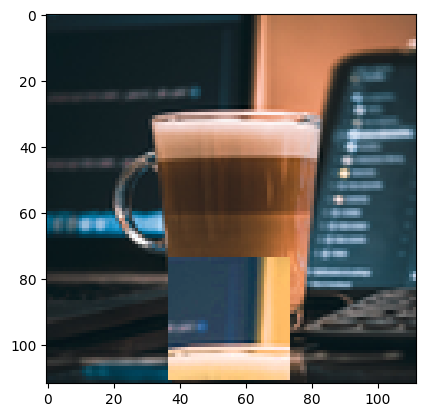

-2 -71
-0.0


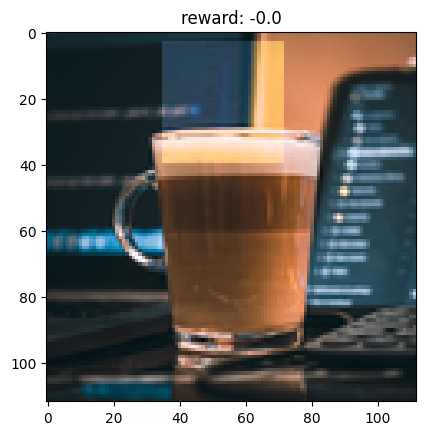

In [88]:
im_b = env.reset()
reward = env.get_reward()
print(f"Reward: {reward}")
plt.imshow(im_b)
plt.show()
# print(f"shift coords: {env.shift_x}, {env.shift_y}")
# print(f"moving coords: {env.crop_x}, {env.crop_y}")
# print(f"diff: {env.crop_x-env.shift_x}, {env.crop_y-env.shift_y}")
targets = env.get_pred_target([0.5+(env.shift_x/(2*env.x_limit)),0.5+(env.shift_y/(2*env.y_limit))])
print(env.crop_x-env.shift_x+0 ,env.crop_y - env.shift_y+0)
im_a, r = env.move_image(env.crop_x-env.shift_x ,env.crop_y - env.shift_y)
print(r)
plt.imshow(im_a)
plt.title(f'reward: {r}')
plt.show()

# utils

In [89]:
import matplotlib.pyplot as plt 
import numpy as np

def plotLearning(scores, filename, x=None, window=5):   
    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-window):(t+1)])
    if x is None:
        x = [i for i in range(N)]
    plt.ylabel('Score')       
    plt.xlabel('Game')                     
    plt.plot(x, running_avg)
    plt.savefig(filename)

# ddpg_torch

In [90]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import Compose, Resize, ToTensor
import numpy as np
import torchvision.transforms as T

# resize = Compose([torch.ToPILImage(),
#                     torch.Resize(112, interpolation=Image.CUBIC),
#                     torch.ToTensor()])

resize = T.Compose([T.ToPILImage(),
                    T.Resize(112, interpolation=Image.CUBIC),
                    T.ToTensor()])

class OUActionNoise(object):
    def __init__(self, mu, sigma=0.15, theta=.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(
                                                            self.mu, self.sigma)

class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='tmp/ddpg'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.checkpoint_file = os.path.join(chkpt_dir,name+'_ddpg')
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.con_bn1 = nn.GroupNorm(16,16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.con_bn2 = nn.GroupNorm(32,32)
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(112))
        convh = conv2d_size_out(conv2d_size_out(112))
        linear_input_size = convw * convh * 32
        self.fc1 = nn.Linear(linear_input_size, self.fc1_dims)
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        torch.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        torch.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        #self.fc1.weight.data.uniform_(-f1, f1)
        #self.fc1.bias.data.uniform_(-f1, f1)
        self.bn1 = nn.LayerNorm(self.fc1_dims)

        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        #f2 = 0.002
        torch.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        torch.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        #self.fc2.weight.data.uniform_(-f2, f2)
        #self.fc2.bias.data.uniform_(-f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        self.action_value = nn.Linear(self.n_actions, self.fc2_dims)
        f3 = 0.003
        self.q = nn.Linear(self.fc2_dims, 1)
        torch.nn.init.uniform_(self.q.weight.data, -f3, f3)
        torch.nn.init.uniform_(self.q.bias.data, -f3, f3)
        #self.q.weight.data.uniform_(-f3, f3)
        #self.q.bias.data.uniform_(-f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cuda:1')

        self.to(self.device)

    def forward(self, state, action):
        state_value = F.relu(self.con_bn1(self.conv1(state)))
        state_value = self.conv2(state_value)
        state_value = self.con_bn2(state_value)
        state_value = F.relu(state_value)
        state_value = self.fc1(state_value.view(state_value.size(0), -1))
        state_value = self.bn1(state_value)
        state_value = F.relu(state_value)
        state_value = self.fc2(state_value)
        state_value = self.bn2(state_value)

        action_value = F.relu(self.action_value(action))
        state_action_value = F.relu(torch.add(state_value, action_value))
        state_action_value = self.q(state_action_value)

        return state_action_value

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(torch.load(self.checkpoint_file))

class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='tmp/ddpg'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.checkpoint_file = os.path.join(chkpt_dir,name+'_ddpg')
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.con_bn1 = nn.GroupNorm(16,16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.con_bn2 = nn.GroupNorm(32,32)
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(112))
        convh = conv2d_size_out(conv2d_size_out(112))
        linear_input_size = convw * convh * 32
        self.fc1 = nn.Linear(linear_input_size, self.fc1_dims)
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        torch.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        torch.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        #self.fc1.weight.data.uniform_(-f1, f1)
        #self.fc1.bias.data.uniform_(-f1, f1)
        self.bn1 = nn.LayerNorm(self.fc1_dims)

        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        #f2 = 0.002
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        torch.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        torch.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        #self.fc2.weight.data.uniform_(-f2, f2)
        #self.fc2.bias.data.uniform_(-f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        #f3 = 0.004
        f3 = 0.003
        self.mu = nn.Linear(self.fc2_dims, self.n_actions)
        torch.nn.init.uniform_(self.mu.weight.data, -f3, f3)
        torch.nn.init.uniform_(self.mu.bias.data, -f3, f3)
        #self.mu.weight.data.uniform_(-f3, f3)
        #self.mu.bias.data.uniform_(-f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cuda:1')

        self.to(self.device)

    def forward(self, state):
        x = self.conv1(state)
        x = self.con_bn1(x)
        x = F.relu(x)
        x = F.relu(self.con_bn2(self.conv2(x)))
        x = self.fc1(x.view(x.size(0), -1))
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = torch.tanh(self.mu(x))

        return x

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(torch.load(self.checkpoint_file))

def transform_obs(observation):
        observation = np.ascontiguousarray(observation, dtype=np.float32) / 255
        observation = torch.from_numpy(observation)
        observation = resize(observation.T)
        observation = observation.unsqueeze(0)
        return observation

class Agent(object):
    def __init__(self, alpha, beta, input_dims, tau, env, gamma=0.99,
                 n_actions=2, max_size=10000, layer1_size=400,
                 layer2_size=300, batch_size=64):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size

        self.actor = ActorNetwork(alpha, input_dims, layer1_size,
                                  layer2_size, n_actions=n_actions,
                                  name='Actor')
        self.critic = CriticNetwork(beta, input_dims, layer1_size,
                                    layer2_size, n_actions=n_actions,
                                    name='Critic')

        self.target_actor = ActorNetwork(alpha, input_dims, layer1_size,
                                         layer2_size, n_actions=n_actions,
                                         name='TargetActor')
        self.target_critic = CriticNetwork(beta, input_dims, layer1_size,
                                           layer2_size, n_actions=n_actions,
                                           name='TargetCritic')

        self.noise = OUActionNoise(mu=np.zeros(n_actions))

        self.update_network_parameters(tau=1)

    
    

    def choose_action(self, observation):
        self.actor.eval()
        observation = transform_obs(observation)
        
        # observation = torch.tensor(observation, dtype=torch.float).to(self.actor.device)
        mu = self.actor.forward(observation.to(self.actor.device)).to(self.actor.device)
        mu_prime = mu + torch.tensor(self.noise(),
                                 dtype=torch.float).to(self.actor.device)
        self.actor.train()
        return mu_prime.cpu().detach().numpy()


    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        state, action, reward, new_state, done = \
                                      self.memory.sample_buffer(self.batch_size)

        reward = torch.tensor(reward, dtype=torch.float).to(self.critic.device)
        done = torch.tensor(done).to(self.critic.device)
        new_state = torch.tensor(new_state, dtype=torch.float).to(self.critic.device)
        action = torch.tensor(action, dtype=torch.float).to(self.critic.device)
        state = torch.tensor(state, dtype=torch.float).to(self.critic.device)

        self.target_actor.eval()
        self.target_critic.eval()
        self.critic.eval()
        target_actions = self.target_actor.forward(new_state)
        critic_value_ = self.target_critic.forward(new_state, target_actions)
        critic_value = self.critic.forward(state, action)

        target = []
        for j in range(self.batch_size):
            target.append(reward[j] + self.gamma*critic_value_[j]*done[j])
        target = torch.tensor(target).to(self.critic.device)
        target = target.view(self.batch_size, 1)

        self.critic.train()
        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        self.critic.optimizer.step()

        self.critic.eval()
        self.actor.optimizer.zero_grad()
        mu = self.actor.forward(state)
        self.actor.train()
        actor_loss = -self.critic.forward(state, mu)
        actor_loss = torch.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_dict = dict(target_critic_params)
        target_actor_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                                      (1-tau)*target_critic_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)

        for name in actor_state_dict:
            actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                                      (1-tau)*target_actor_dict[name].clone()
        self.target_actor.load_state_dict(actor_state_dict)

        """
        #Verify that the copy assignment worked correctly
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(target_critic_params)
        actor_state_dict = dict(target_actor_params)
        print('\nActor Networks', tau)
        for name, param in self.actor.named_parameters():
            print(name, torch.equal(param, actor_state_dict[name]))
        print('\nCritic Networks', tau)
        for name, param in self.critic.named_parameters():
            print(name, torch.equal(param, critic_state_dict[name]))
        input()
        """
    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()

    def check_actor_params(self):
        current_actor_params = self.actor.named_parameters()
        current_actor_dict = dict(current_actor_params)
        original_actor_dict = dict(self.original_actor.named_parameters())
        original_critic_dict = dict(self.original_critic.named_parameters())
        current_critic_params = self.critic.named_parameters()
        current_critic_dict = dict(current_critic_params)
        print('Checking Actor parameters')

        for param in current_actor_dict:
            print(param, torch.equal(original_actor_dict[param], current_actor_dict[param]))
        print('Checking critic parameters')
        for param in current_critic_dict:
            print(param, torch.equal(original_critic_dict[param], current_critic_dict[param]))
        input()

/home/ec2-user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  from ipykernel import kernelapp as app
/home/ec2-user/.local/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


# Main

Crop coords: (44, 47, 81, 84)
75
Episode: 0.25 Score: 72.3, x: 4.01, y: 3.53
Episode: 0.50 Score: 82.31, x: 17.3, y: -6.82
Episode: 0.75 Score: -311.19, x: 13.73, y: -23.15
Episode: 0.100 Score: -754.31, x: -1.97, y: -9.11
Episode: 0.125 Score: -1083.87, x: -20.15, y: 6.18
Episode: 0.150 Score: -1454.38, x: -30.4, y: 17.33
Episode: 0.175 Score: -1824.88, x: -36.96, y: 40.45
Episode: 0.200 Score: -2195.39, x: -47.04, y: 61.08


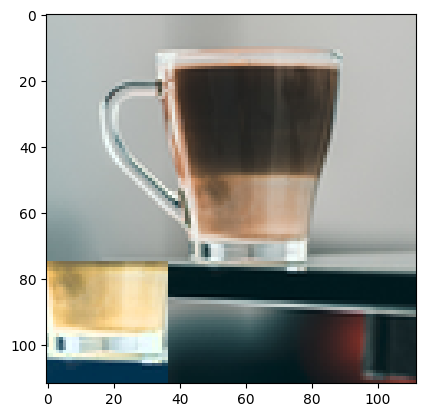

Episode: 0.225 Score: -2565.9, x: -44.83, y: 64.06
Episode: 0.250 Score: -2936.4, x: -48.99, y: 35.37
Episode: 0.275 Score: -3318.51, x: -11.15, y: -16.96
Episode: 0.300 Score: -3814.35, x: 24.71, y: -41.84
Episode: 0.325 Score: -4288.58, x: 40.93, y: -36.61


In [91]:
# from ddpg_torch import Agent
# import gym
import numpy as np
# from utils import plotLearning

# env = gym.make('LunarLanderContinuous-v2')
env = envs[0]
agent = Agent(alpha=0.000025, beta=0.00025, input_dims=[3,112,112], tau=0.001, env=env,
              batch_size=64,  layer1_size=400, layer2_size=300, n_actions=2)

#agent.load_models()
np.random.seed(0)

score_history = []
for i in range(1000):
    obs = env.reset()
    done = False
    score = 0
    t = 0
    while not done:
        t += 1
        act = agent.choose_action(obs)
        new_state, reward, done = env.step(act)
        agent.remember(transform_obs(obs), act, reward, transform_obs(new_state), int(done))
        agent.learn()
        score += reward
        obs = new_state
        if t%25 == 0:
            x_amount = act[0][0]*env.fixed_image.size[0]
            y_amount = act[0][1]*env.fixed_image.size[1]
            print(f'Episode: {i}.{t} Score: {score.round(2)}, x: {x_amount.round(2)}, y: {y_amount.round(2)}')
            # plot the state
        if t%200 == 0:
            # plot the state
            plt.imshow(obs)
            plt.show()
            
        #env.render()
    score_history.append(score)

    #if i % 25 == 0:
    #    agent.save_models()

    print('episode ', i, 'score %.2f' % score,
          'trailing 100 games avg %.3f' % np.mean(score_history[-100:]))

filename = 'LunarLander-alpha000025-beta00025-400-300.png'
plotLearning(score_history, filename, window=100)